In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("../../..")

In [3]:
import omegaconf
from shell.utils.experiment_utils import *
from shell.fleet.utils.fleet_utils import *
from shell.utils.metric import *
import matplotlib.pyplot as plt
from shell.fleet.network import TopologyGenerator
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
from shell.fleet.fleet import Agent, Fleet
from shell.fleet.data.data_utilize import *
from shell.fleet.data.recv import *

from sklearn.manifold import TSNE
from torchvision.utils import make_grid
from shell.fleet.data.data_utilize import *
import logging
from sklearn.metrics import f1_score
import os
from shell.fleet.data.recv_utils import *
from tqdm import tqdm
import argparse
from functools import partial
from torchvision.utils import make_grid
from shell.utils.oodloss import OODSeparationLoss
from pythresh.thresholds.dsn import DSN
from pythresh.thresholds.aucp import AUCP
from pythresh.thresholds.boot import BOOT
from pythresh.thresholds.zscore import ZSCORE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from collections import defaultdict

logging.basicConfig(level=logging.INFO)

In [4]:
dataset = "mnist"
algo = "modular"
algo = "monolithic"
prefilter_strategy = "oracle"
scorer = "cross_entropy"

experiment_folder = "experiment_results"
experiment_name = "vanilla_fix_bug_compute_loss_encodev2"

use_contrastive = True
num_trains_per_class = 64
seed = 0
num_neighbors = 10
parallel = False


add_data_prefilter_strategy = "both"
assign_labels_strategy = "same_as_query"

save_dir = get_save_dir(experiment_folder, experiment_name,
                        dataset, algo, num_trains_per_class, use_contrastive, seed)

In [5]:
def modify_cfg(net_cfg, agent_cfg, train_cfg, fleet_additional_cfg, cfg):
    # train_cfg['num_epochs'] = 15
    train_cfg['component_update_freq'] = train_cfg['num_epochs']
    train_cfg['save_freq'] = 10
    # num_comms_per_task = 3 # should really add 1 because the last comm is kinda basically useless
    num_comms_per_task = 6 # should really add 1 because the last comm is kinda basically useless
    # for the current task.
    comm_freq = train_cfg['num_epochs'] // num_comms_per_task

    # train_cfg['memory_size'] = 32
    shared_memory_size = agent_cfg['memory_size']
    query_task_mode = 'current' if algo == 'modular' else 'all'
    cfg.sharing_strategy = DictConfig({
        "name": "recv_data",
        "scorer": scorer,
        "num_queries": 20,
        'num_data_neighbors': 5,
        'num_filter_neighbors': 5,
        'num_coms_per_round': 2,
        "query_score_threshold": 0.0,
        "shared_memory_size": shared_memory_size,
        "comm_freq": comm_freq,
        "prefilter_strategy": prefilter_strategy,
        "use_ood_separation_loss": False,
        "assign_labels_strategy": assign_labels_strategy,
        "add_data_prefilter_strategy": add_data_prefilter_strategy,
        "sync_base": False,
        'pre_or_post_comm': 'post',
        'query_task_mode': query_task_mode,
    })

    return net_cfg, agent_cfg, train_cfg, fleet_additional_cfg, cfg

In [6]:
fleet = setup_fleet(save_dir, task_id=3, modify_cfg=modify_cfg, parallel=False)

INFO:root:Class sequence: [5 0 4 3 4 6 4 3 8 0 1 0 5 9 6 4 9 0 3 0]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)


{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 20}, 'dataset': {'dataset_name': 'mnist', 'num_tasks': 10, 'num_classes_per_task': 2, 'with_replacement': True, 'num_trains_per_class': 64, 'num_vals_per_class': 50, 'remap_labels': True}, 'net': {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0}, 'sharing_strategy': {'name': 'no_sharing', 'num_coms_per_round': 0}, 'seed': 0, 'algo': 'monolithic', 'job_name': 'mnist_monolithic_numtrain_64_contrastive', 'num_agents': 8, 'root_save_dir': 'experiment_results/vanilla_fix_bug_compute_loss_encodev2', 'parallel': True, 'num_init_tasks': 4, 'agent': {'save_dir': '${root_save_dir}/${job_name}/${dataset.dataset_name}/${algo}/seed_${seed}', 'batch_size': 64, 'memory_size': 32, 'improvement_threshold': 0.05, 'use_contrastive': True}}


INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [4 7 5 7 6 0 3 0 5 0 3 6 2 7 6 7 6 1 0 5]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [6 7 7 8 4 1 1 8 6 1 6 4 5 7 8 0 2 3 0 3]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 

i_size 28
num_classes 2
net_cfg {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0, 'i_size': 28, 'num_classes': 2, 'num_tasks': 10, 'num_init_tasks': 4, 'use_contrastive': True}
<class 'shell.learners.er_nocomponents.NoComponentsER'>


In [7]:
# """
# Viz query. Each row is a task. Each column is a query.
# The label is {score}/{y}/{y_pred}, and
# `red` means y != y_pred, `green` means y == y_pred.
# """
# agent_id = 0
# query_task_id = 0
# agent = fleet.agents[agent_id]
# X_queries, y_queries, y_pred_queries, score_queries = agent.compute_query(task_id=4, debug_return=True)

# num_neighbors = len(X_queries.keys())
# num_queries = max([len(X_queries[i]) for i in range(num_neighbors)])
# fig, axes = plt.subplots(num_neighbors, num_queries, figsize=(num_queries*2, num_neighbors*2))

# rows = [f"task {task_id}" for task_id in range(num_neighbors)]
# pad = 0
# for ax, row in zip(axes[:,0], rows):
#     ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
#                 xycoords=ax.yaxis.label, textcoords='offset points',
#                 size='large', ha='right', va='center', rotation=90)

# for task_id in range(num_neighbors):
#     for query_id in range(len(X_queries[task_id])):
#         ax = axes[task_id, query_id]
#         ax.set_xticks([])
#         ax.set_yticks([])

#         ax.imshow(X_queries[task_id][query_id].squeeze(), cmap="gray")
#         color = "green" if y_queries[task_id][query_id]  ==  y_pred_queries[task_id][query_id] else "red"
#         ax.set_title(f"{score_queries[task_id][query_id]:.2f}/{y_queries[task_id][query_id]}/{y_pred_queries[task_id][query_id]}",
#                      color=color)

   
# plt.tight_layout()

In [8]:
fleet.communicate(task_id=4, end_epoch=92, comm_freq=10, num_epochs=100)

In [9]:
agent_id = 0
agent = fleet.agents[agent_id]
neighbor_id = 1
task_id = 0
# query = agent.query[task_id]
# Y = agent.incoming_extra_info[neighbor_id]['Y_neighbors'][task_id]
# Y

In [10]:
# X, y, t = agent.agent.shared_replay_buffers[task_id].get_tensors()
# plt.imshow(make_grid(X, nrow=8).permute(1,2,0))
# print(y)

In [11]:
# extra_info = agent.incoming_extra_info[neighbor_id]
# shared_global_Y = extra_info['Y_neighbors'][task_id]
# shared_local_Y = get_local_labels_for_task(
#     shared_global_Y.flatten(), task_id, agent.dataset.class_sequence, agent.dataset.num_classes_per_task)
# shared_local_Y.dtype

In [12]:
# shared_local_Y

In [13]:
# valid_mask

In [14]:
# plt.imshow(make_grid(query).permute(1, 2, 0))

In [15]:
# X = agent.incoming_data[neighbor_id][task_id]
# X = X.reshape(-1, *X.shape[2:])
# X.shape

In [16]:
# extra_info = agent.incoming_extra_info[neighbor_id]

# task_neighbors_prefilter = extra_info[
#     'task_neighbors_prefilter'][task_id]
# valid_rows_mask = ~torch.all(
#     task_neighbors_prefilter == -1, dim=1)

# valid_rows_mask.unsqueeze(1).expand(-1, task_neighbors_prefilter.shape[1]).reshape(-1).shape

In [17]:
# task_neighbors_prefilter.shape

In [18]:
# get_local_labels_for_task(Y.flatten(), task_id, agent.dataset.class_sequence, 
#                           agent.dataset.num_classes_per_task).reshape(Y.shape)

In [19]:
# agent.incoming_extra_info[neighbor_id]['task_neighbors_prefilter'][task_id]

In [20]:
# agent.incoming_extra_info[neighbor_id]['X_neighbors'][task_id].shape

In [21]:
# X = agent.incoming_extra_info[neighbor_id]['X_neighbors'][task_id]
# X = X.reshape(-1, *X.shape[2:])
# plt.imshow(make_grid(X).permute(1,2,0));

In [22]:
# neighbor_data = [agent.incoming_extra_info[neigh_id]['X_neighbors'][query_task_id] for neigh_id in agent.incoming_data.keys()]
# neighbor_data = [task_data.reshape(-1, *task_data.shape[2:]) for task_data in neighbor_data]

# # Calculate number of rows (tasks) and columns (queries)
# num_neighbors = len(neighbor_data)
# num_queries = max([len(data) for data in neighbor_data])  # Assuming each task has a list of data

# # Create subplots
# fig, axes = plt.subplots(num_neighbors, num_queries, figsize=(num_queries * 2, num_neighbors * 2))

# # Set row labels
# rows = [f"neighbor {neigh_id}" for neigh_id in agent.incoming_data.keys()]
# pad = 0
# for ax, row in zip(axes[:, 0], rows):
#     ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
#                 xycoords=ax.yaxis.label, textcoords='offset points',
#                 size='large', ha='right', va='center', rotation=90)

# # Plot data
# for task_id, task_data in enumerate(neighbor_data):
#     for query_id in range(len(task_data)):
#         ax = axes[task_id, query_id]
#         ax.set_xticks([])
#         ax.set_yticks([])

#         ax.imshow(task_data[query_id].squeeze(), cmap="gray")

# plt.tight_layout()

In [23]:
# replay = agent.agent.shared_replay_buffers[query_task_id]
# plt.imshow(make_grid(replay.tensors[0][:len(replay)]).permute(1,2,0));

## The performance of baseline fleet

In [24]:
test_task_id = 4
fleet = setup_fleet(save_dir, task_id=test_task_id, modify_cfg=modify_cfg, parallel=False)
baseline_perfs = fleet.eval_test(test_task_id)

INFO:root:Class sequence: [5 0 4 3 4 6 4 3 8 0 1 0 5 9 6 4 9 0 3 0]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)


{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 20}, 'dataset': {'dataset_name': 'mnist', 'num_tasks': 10, 'num_classes_per_task': 2, 'with_replacement': True, 'num_trains_per_class': 64, 'num_vals_per_class': 50, 'remap_labels': True}, 'net': {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0}, 'sharing_strategy': {'name': 'no_sharing', 'num_coms_per_round': 0}, 'seed': 0, 'algo': 'monolithic', 'job_name': 'mnist_monolithic_numtrain_64_contrastive', 'num_agents': 8, 'root_save_dir': 'experiment_results/vanilla_fix_bug_compute_loss_encodev2', 'parallel': True, 'num_init_tasks': 4, 'agent': {'save_dir': '${root_save_dir}/${job_name}/${dataset.dataset_name}/${algo}/seed_${seed}', 'batch_size': 64, 'memory_size': 32, 'improvement_threshold': 0.05, 'use_contrastive': True}}


INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [4 7 5 7 6 0 3 0 5 0 3 6 2 7 6 7 6 1 0 5]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [6 7 7 8 4 1 1 8 6 1 6 4 5 7 8 0 2 3 0 3]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence

i_size 28
num_classes 2
net_cfg {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0, 'i_size': 28, 'num_classes': 2, 'num_tasks': 10, 'num_init_tasks': 4, 'use_contrastive': True}
<class 'shell.learners.er_nocomponents.NoComponentsER'>


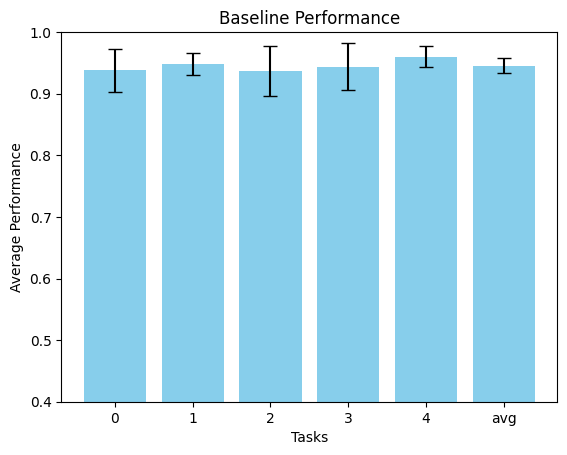

In [25]:
df = pd.DataFrame(baseline_perfs)
df.columns = df.columns.astype(str)

task_stats = df.agg(["mean", "std"])
plt.bar(task_stats.columns, task_stats.loc['mean'], yerr=task_stats.loc['std'], capsize=5, color='skyblue')
plt.xlabel('Tasks')
plt.ylabel('Average Performance')
plt.title('Baseline Performance')
plt.ylim(0.4, 1.0)  
plt.show()

In [26]:
task_stats

,0,1,2,3,4,avg
mean,0.937849,0.948558,0.936395,0.944152,0.960156,0.945422
std,0.035141,0.018218,0.040616,0.038275,0.017126,0.012248


In [27]:
df

,0,1,2,3,4,avg
0,0.969017,0.955823,0.901031,0.930221,0.969294,0.945077
1,0.893035,0.958854,0.951496,0.910553,0.958333,0.934454
2,0.953172,0.928072,0.977799,0.974870,0.983278,0.963438
3,0.874875,0.965327,0.935821,0.975904,0.969050,0.944195
4,0.949246,0.942346,0.861561,0.932629,0.962621,0.929681
5,0.936605,0.976626,0.980886,0.994744,0.923656,0.962504
6,0.959896,0.930470,0.960346,0.879536,0.957216,0.937493
7,0.966946,0.930948,0.922217,0.954761,0.957799,0.946534


## Receiver Sharing

In [29]:
fleet = setup_fleet(save_dir, task_id=test_task_id-1, modify_cfg=modify_cfg, parallel=True)
before_sharing_and_learn = fleet.eval_test(test_task_id)

INFO:root:Class sequence: [5 0 4 3 4 6 4 3 8 0 1 0 5 9 6 4 9 0 3 0]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)


{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 20}, 'dataset': {'dataset_name': 'mnist', 'num_tasks': 10, 'num_classes_per_task': 2, 'with_replacement': True, 'num_trains_per_class': 64, 'num_vals_per_class': 50, 'remap_labels': True}, 'net': {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0}, 'sharing_strategy': {'name': 'no_sharing', 'num_coms_per_round': 0}, 'seed': 0, 'algo': 'monolithic', 'job_name': 'mnist_monolithic_numtrain_64_contrastive', 'num_agents': 8, 'root_save_dir': 'experiment_results/vanilla_fix_bug_compute_loss_encodev2', 'parallel': True, 'num_init_tasks': 4, 'agent': {'save_dir': '${root_save_dir}/${job_name}/${dataset.dataset_name}/${algo}/seed_${seed}', 'batch_size': 64, 'memory_size': 32, 'improvement_threshold': 0.05, 'use_contrastive': True}}


INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [4 7 5 7 6 0 3 0 5 0 3 6 2 7 6 7 6 1 0 5]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [6 7 7 8 4 1 1 8 6 1 6 4 5 7 8 0 2 3 0 3]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence

i_size 28
num_classes 2
net_cfg {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0, 'i_size': 28, 'num_classes': 2, 'num_tasks': 10, 'num_init_tasks': 4, 'use_contrastive': True}
<class 'shell.learners.er_nocomponents.NoComponentsER'>


2024-02-13 14:16:07,158	INFO worker.py:1544 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
(ParallelRecvDataAgent pid=3422427) INFO:root:Agent: node_id: 0, seed: 0
(ParallelRecvDataAgent pid=3422428) INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:Created fleet with 8 agents
INFO:root:Adding neighbors...
(ParallelRecvDataAgent pid=3422429) INFO:root:Agent: node_id: 2, seed: 2000
(ParallelRecvDataAgent pid=3422430) INFO:root:Agent: node_id: 3, seed: 3000
(ParallelRecvDataAgent pid=3422530) INFO:root:Agent: node_id: 4, seed: 4000
(ParallelRecvDataAgent pid=3422600) INFO:root:Agent: node_id: 5, seed: 5000
(ParallelRecvDataAgent pid=3422653) INFO:root:Agent: node_id: 6, seed: 6000
(ParallelRecvDataAgent pid=3422733) INFO:root:Agent: node_id: 7, seed: 7000
INFO:root:Fleet initialized


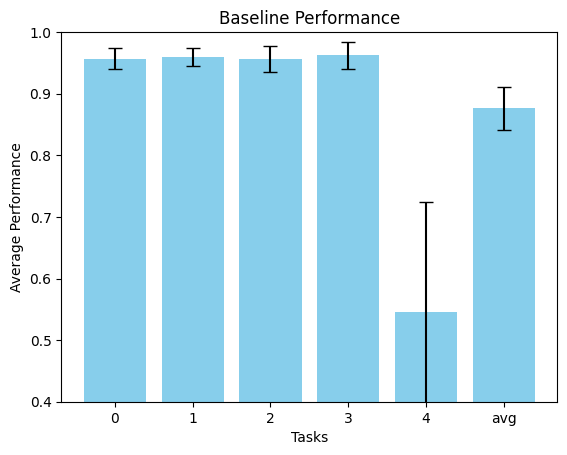

In [30]:
df = pd.DataFrame(before_sharing_and_learn)
df.columns = df.columns.astype(str)

task_stats = df.agg(["mean", "std"])
plt.bar(task_stats.columns, task_stats.loc['mean'], yerr=task_stats.loc['std'], capsize=5, color='skyblue')
plt.xlabel('Tasks')
plt.ylabel('Average Performance')
plt.title('Baseline Performance')
plt.ylim(0.4, 1.0)  
plt.show()

In [31]:
task_stats

,0,1,2,3,4,avg
mean,0.956777,0.959239,0.956761,0.962415,0.545781,0.876194
std,0.016861,0.014479,0.020900,0.022264,0.178981,0.035119


In [32]:
new_save_dir  =f'experiment_results/test_recv_global_labels/{algo}/{dataset}/{assign_labels_strategy}/{add_data_prefilter_strategy}' 
print(fleet.get_save_dir())
fleet.change_save_dir(new_save_dir)
print(fleet.get_save_dir())

['experiment_results/vanilla_fix_bug_compute_loss_encodev2/mnist_monolithic_numtrain_64_contrastive/mnist/monolithic/seed_0/agent_0', 'experiment_results/vanilla_fix_bug_compute_loss_encodev2/mnist_monolithic_numtrain_64_contrastive/mnist/monolithic/seed_0/agent_1', 'experiment_results/vanilla_fix_bug_compute_loss_encodev2/mnist_monolithic_numtrain_64_contrastive/mnist/monolithic/seed_0/agent_2', 'experiment_results/vanilla_fix_bug_compute_loss_encodev2/mnist_monolithic_numtrain_64_contrastive/mnist/monolithic/seed_0/agent_3', 'experiment_results/vanilla_fix_bug_compute_loss_encodev2/mnist_monolithic_numtrain_64_contrastive/mnist/monolithic/seed_0/agent_4', 'experiment_results/vanilla_fix_bug_compute_loss_encodev2/mnist_monolithic_numtrain_64_contrastive/mnist/monolithic/seed_0/agent_5', 'experiment_results/vanilla_fix_bug_compute_loss_encodev2/mnist_monolithic_numtrain_64_contrastive/mnist/monolithic/seed_0/agent_6', 'experiment_results/vanilla_fix_bug_compute_loss_encodev2/mnist_mono

In [33]:
fleet.train_and_comm(task_id=test_task_id)

(ParallelRecvDataAgent pid=3422427) INFO:root:epochs: 0, training task: 4
(ParallelRecvDataAgent pid=3422427) INFO:root:	task: 0	loss: 0.42918714	acc: 0.976
(ParallelRecvDataAgent pid=3422427) INFO:root:	task: 1	loss: 0.34338886	acc: 0.976
(ParallelRecvDataAgent pid=3422427) INFO:root:	task: 2	loss: 0.39248622	acc: 0.961
(ParallelRecvDataAgent pid=3422427) INFO:root:	task: 3	loss: 0.36483764	acc: 0.970
(ParallelRecvDataAgent pid=3422427) INFO:root:	task: 4	loss: 0.70036920	acc: 0.390
(ParallelRecvDataAgent pid=3422427) INFO:root:	task: avg	loss: 0.44605381	acc: 0.855
(ParallelRecvDataAgent pid=3422428) INFO:root:epochs: 0, training task: 4
(ParallelRecvDataAgent pid=3422428) INFO:root:	task: 0	loss: 0.41123773	acc: 0.962
(ParallelRecvDataAgent pid=3422428) INFO:root:	task: 1	loss: 0.39855686	acc: 0.956
(ParallelRecvDataAgent pid=3422428) INFO:root:	task: 2	loss: 0.42687120	acc: 0.954
(ParallelRecvDataAgent pid=3422428) INFO:root:	task: 3	loss: 0.40204477	acc: 0.950
(ParallelRecvDataAge

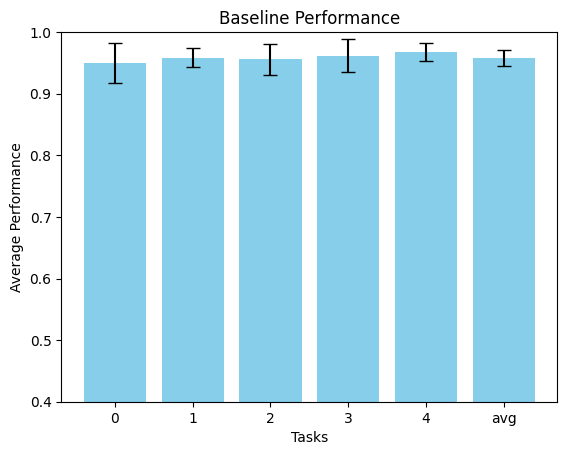

In [34]:
after_sharing_and_learn = fleet.eval_test(test_task_id)
df = pd.DataFrame(after_sharing_and_learn)
df.columns = df.columns.astype(str)

task_stats = df.agg(["mean", "std"])
plt.bar(task_stats.columns, task_stats.loc['mean'], yerr=task_stats.loc['std'], capsize=5, color='skyblue')
plt.xlabel('Tasks')
plt.ylabel('Average Performance')
plt.title('Baseline Performance')
plt.ylim(0.4, 1.0)  
plt.show()

In [35]:
task_stats

,0,1,2,3,4,avg
mean,0.949927,0.958238,0.955762,0.962005,0.967201,0.958627
std,0.032007,0.015381,0.025397,0.027412,0.014679,0.013128


In [36]:
df

,0,1,2,3,4,avg
0,0.978632,0.973394,0.973711,0.973896,0.982088,0.976344
1,0.933333,0.945833,0.946852,0.929146,0.948184,0.940670
2,0.974320,0.948551,0.965517,0.966809,0.988533,0.968746
3,0.882353,0.968844,0.960697,0.982430,0.972252,0.953315
4,0.960302,0.959245,0.900835,0.965309,0.965390,0.950216
5,0.946319,0.983232,0.986946,0.996178,0.946258,0.971787
6,0.946354,0.943763,0.954245,0.913306,0.968557,0.945245
7,0.977800,0.943044,0.957295,0.968964,0.966346,0.962690


In [37]:
agent = fleet.agents[0]
shared_reps = ray.get(agent.get_shared_replay_buffers.remote())
reps = ray.get(agent.get_replay_buffers.remote())
query = ray.get(agent.get_query.remote())

In [ ]:
AgentCls = get_agent_cls(cfg.sharing_strategy, cfg.algo, parallel)
FleetCls = get_fleet(cfg.sharing_strategy, parallel)
fleet = setup_fleet()
new_save_dir  =f'experiment_results/test_recv_global_labels/{algo}/{dataset}/{assign_labels_strategy}/{add_data_prefilter_strategy}' 
fleet.change_save_dir(new_save_dir)
print(fleet.get_save_dir())

In [ ]:
fleet.update_replay_buffers(test_task_id)
fleet.load_model_from_ckpoint(task_ids=test_task_id)

In [ ]:
agent = fleet.agents[0].agent

In [ ]:
agent.net.device

In [ ]:
print('REPLAY BUFFER')
fig, axes = plt.subplots(1, len(reps), figsize=(len(reps)*2, 2))
for task_id, rep in sorted(reps.items()):
        X, y, t = rep.get_tensors()
        print('task:', task_id, agent.compute_cross_entropy_loss(X.to('cuda'), y.to('cuda'),  t[0].item()))
        # print(task_id, y,)
        axes[task_id].imshow(make_grid(X).permute(1,2,0))
        axes[task_id].axis('off')

In [ ]:
print('SHARED REPLAY BUFFER')
fig, axes = plt.subplots(1, len(shared_reps), figsize=(len(reps)*2, 2))
for task_id, shared_rep in sorted(shared_reps.items()):
    X, y, t = shared_rep.get_tensors()
    print('task:', task_id, agent.compute_cross_entropy_loss(X.to('cuda'), y.to('cuda'),  t[0].item()))
    # print(task_id, y, '\n')
    axes[task_id].imshow(make_grid(X).permute(1,2,0))
    axes[task_id].axis('off')

In [ ]:
fig, ax = plt.subplots(1, len(query), figsize=(len(query)*2, 2))
for task_id, task_query in query.items():
    ax[task_id].imshow(make_grid(task_query).permute(1,2,0))
    ax[task_id].axis('off')

__TODO__

This is probably the same class balancing problem!